# Analysis of missing pulses   

For a given flux and exposure time this notebook analyzes the missing ('non-reconstructed') photons and plots the
distribution of separations to their partner ('Bad-reconstructed' pulse).

1. Import modules   
2. Read parameters of simulation   
3. Analysis of bad/non-reconstructed pulses   
   * 3.1. Check distances between a missing photon and its corresponding "bad-reconstructed" photon:    
        - For each simulation:   
            * read CSV file with assignation of *missing* & *bad-reconstructed*   
            * for each *missing* photon: get *bad-reconstructed* partner   
                * read info in `piximpact` file   
                * calculate minimum of the distances to all *bad-reconstructed*: this is its partner   
                * save distance to global list of distances    
                * Alert if:   
                    * No *bad-reconstructed* photon is found for each *missing* photon: raise Error    
                    * Separation [*missing*-*bad_renconstructed*] > 100: raise Error
                    * Separation [*missing*-*bad_renconstructed*] > 30: warning to check particular cases    
    * 3.2 Plot histograms of:   
        - separations   
        - energies:
            - energies of missing photons   
            - energies of badrecons photons   
            - energies of impact photons   


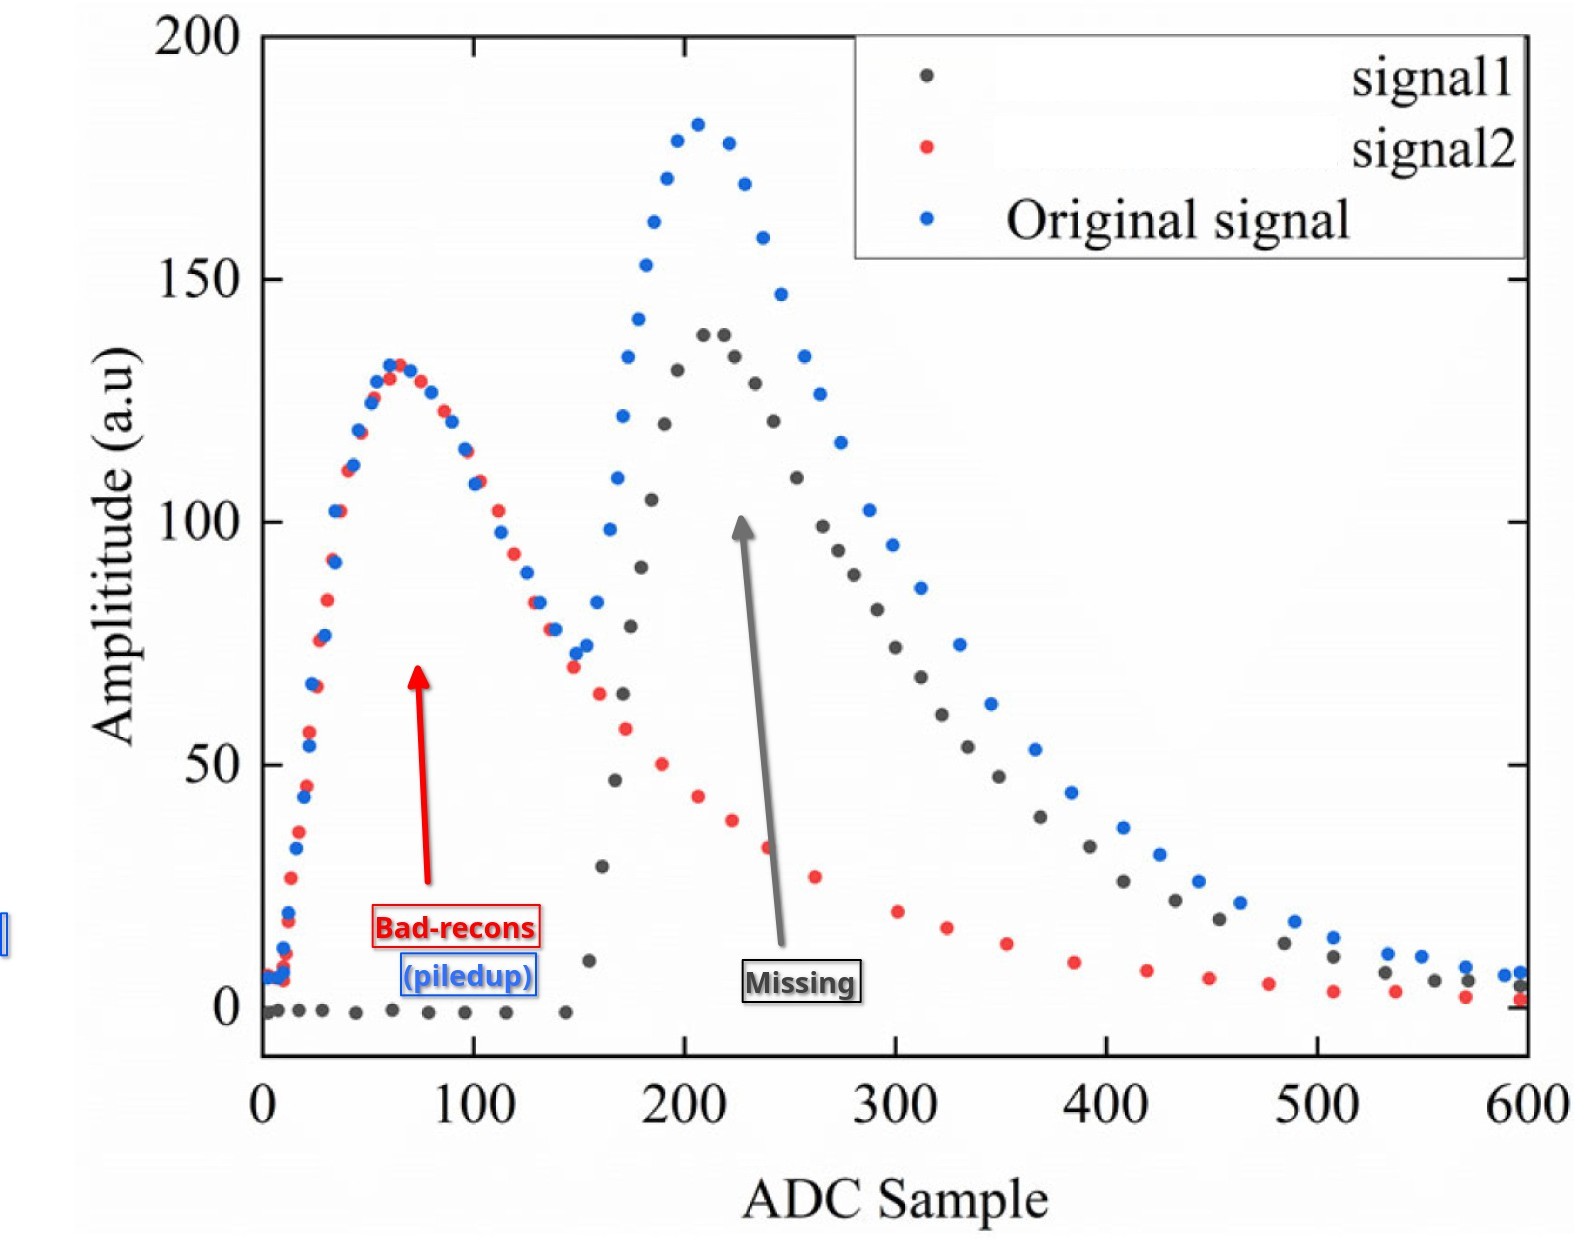

In [1]:
from IPython.display import display, Image
display(Image("images/pileup.png", width=350))

### Import modules

In [2]:
# Do standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from astropy.io import fits, ascii
from astropy.table import Table
from astropy.visualization import hist

import os
import ast
import auxiliary 

### Set simulation parameters

In [3]:
global_csv_file = "info_nofilt_infoc_global_0.500mCrab.csv"
verbose = 1

In [4]:
nsims = 100
sampling_rate=130210 #Hz
secondary_samples = 1563
close_dist_toxifusim = 100
pileup_dist = 30
auxiliary.verbose = verbose

# get filter from file name
filter = global_csv_file.split("_")[1]
# get focus from file name
focus = global_csv_file.split("_")[2]
# get flux from file name
flux_mcrab = float(global_csv_file.split("_")[4].split("m")[0])
fluxDir = f"{os.getcwd()}/flux{flux_mcrab:.2f}mcrab/"
print(f"Filter: {filter}, Focus: {focus}, Flux: {flux_mcrab} mCrab")


Filter: nofilt, Focus: infoc, Flux: 0.5 mCrab


## Analysis of missing and bad-reconstructed photons

### Pile-up photons separations 

Check distances between a missing photon and its corresponding "bad-reconstructed" photon

In [14]:
all_missing_distances = list()
all_missing_energies  = list()
all_badrecons_energies = list()
miss0_energies = list() # energies of the first missing photon
all_badrecons_energies_secondaries = list()
all_badrecons_energies_lowres = list()
all_badrecons_energies_primaries = list()
Ntimes_couples_far = 0

for i in range(nsims):
    isim = i + 1
    #if not isim == 1:
    #    continue
    csv_file = f"{fluxDir}/sim_{isim}/00_info_{filter}_{focus}_sim{isim}_missing.csv"
    missing_table = pd.read_csv(csv_file, converters={"Bad-reconstructed photons": ast.literal_eval,
                                                    "Bad-reconstructed photons energy": ast.literal_eval,
                                                    "Non-reconstructed photons": ast.literal_eval,
                                                    "Non-reconstructed photons energies": ast.literal_eval,
                                                    "GRADE1 Bad-recons": ast.literal_eval,
                                                    "GRADE2 Bad-recons": ast.literal_eval})
    
    #read table row by row:
    # 1st column: pixel id
    # 2nd column: PH_ID of the badrecons photon
    # 3rd column: energy of the badrecons photon
    # 4th column: list of the PH_IDs of the missing photons for the badrecons photon
    # 5th column: list of the energies of the missing photons for the badrecons photon
    # 6th column: GRADE1 of the badrecons photon
    # 7th column: GRADE2 of the badrecons photon

    # read table rows grouped by pixel
    pixels_in_table = missing_table["Pixel"].unique()
    for ipixel in pixels_in_table:
        rows_with_same_pixel = missing_table[missing_table["Pixel"] == ipixel]
            
        # identify piximpact file for pixel
        piximpact_file = glob.glob(f"{fluxDir}/sim_{isim}/crab_flux{flux_mcrab:.2f}_Emin2_Emax10_exp*_RA0.0_Dec0.0_{filter}_{focus}_pixel{ipixel}_piximpact.fits")
        if len(piximpact_file) == 0:
            print(f"sim {isim}, pixel {ipixel}: no piximpact file found")
            raise ValueError("No piximpact file found")
        if len(piximpact_file) > 1:
            print(f"sim {isim}, pixel {ipixel}: more than one piximpact file found")
            raise ValueError("More than one piximpact file found")
        piximpact_file = piximpact_file[0]
        # read TIME and PH_ID columns of piximpact FITS file
        with fits.open(piximpact_file) as hdul:
            piximpact_data = hdul[1].data
            time_piximpact = piximpact_data["TIME"].copy()
            ph_id = piximpact_data["PH_ID"].copy()
        
        #for i, row in missing_table.iterrows():
        for irow, row in rows_with_same_pixel.iterrows():
            bad_recons_ph_id_irow = row["Bad-reconstructed photons"]
            bad_recons_energy_irow = row["Bad-reconstructed photons energy"]
            missing_phs_id_irow = row["Non-reconstructed photons"]
            missing_energies_irow = row["Non-reconstructed photons energies"]
            bad_recons_grade1_irow = row["GRADE1 Bad-recons"]
            bad_recons_grade2_irow = row["GRADE2 Bad-recons"]
            message = (f"For sim {isim}, pixel {ipixel}: \n"
                       f"    bad-recons ph: {bad_recons_ph_id_irow}, energy: {bad_recons_energy_irow} \n"
                       f"    missing phs: {missing_phs_id_irow}, energies: {missing_energies_irow} \n"
                       f"    grade1 {bad_recons_grade1_irow}, grade2 {bad_recons_grade2_irow}")
            auxiliary.vprint(message)

            # foreach missing photon, find the TIME distance to its 'partner'-bad-reconstructed photon
            for imi in range(len(missing_phs_id_irow)):
                imissing = missing_phs_id_irow[imi]
                missing_energy = missing_energies_irow[imi]
                missing_time = time_piximpact[ph_id == imissing][0] 
                bad_time = time_piximpact[ph_id == bad_recons_ph_id_irow][0]
                time_diff_samples = np.abs(missing_time - bad_time)*sampling_rate
                if time_diff_samples > close_dist_toxifusim:
                    # this should never happen, as only couples separated by less than close_dist_toxifusim are simulated
                    message = f"sim {isim}, pixel {ipixel}: missing ph {imissing} and bad ph {bad_recons_ph_id_irow} are separated by {time_diff_samples:.2f} samples"
                    print(message)
                    raise ValueError(message)
                if time_diff_samples > pileup_dist:
                    message = f"Sim {isim}, pixel{ipixel}:Time difference between missing and bad reconstructed photons is too large:{time_diff_samples:.2f} samples"
                    print(message)
                    Ntimes_couples_far += 1
                # append the minimum time difference to the list of missing distances
                all_missing_distances.append(time_diff_samples)
                all_missing_energies.append(missing_energy)
                auxiliary.vprint(f"sim {isim}, pixel {ipixel}, missing ph {imissing}, bad ph {bad_recons_ph_id_irow}, min time diff {time_diff_samples:.2f}")
            imissing0 = missing_phs_id_irow[0]
            
            # check bad-recons photons
            if bad_recons_grade2_irow <= secondary_samples:
                auxiliary.vprint(f"........bad-recons ph {bad_recons_ph_id_irow}, grade1 {bad_recons_grade1_irow}, grade2 {bad_recons_grade2_irow}: SECONDARY")
                all_badrecons_energies_secondaries.append(bad_recons_energy_irow)
            elif bad_recons_grade1_irow == 8:
                auxiliary.vprint(f"........bad-recons ph {bad_recons_ph_id_irow}, grade1 {bad_recons_grade1_irow}, grade2 {bad_recons_grade2_irow}: LOWRES")
                all_badrecons_energies_lowres.append(bad_recons_energy_irow)
            else:
                auxiliary.vprint(f"........bad-recons ph {bad_recons_ph_id_irow}, grade1 {bad_recons_grade1_irow}, grade2 {bad_recons_grade2_irow}: PRIMARY")
                all_badrecons_energies_primaries.append(bad_recons_energy_irow)
            all_badrecons_energies.append(bad_recons_energy_irow)
            # save energy of first missing photon for bad-recons photon
            miss0_energies.append(missing_energies_irow[0])
            

For sim 1, pixel 24: 
    bad-recons ph: 54597, energy: 1.4634293 
    missing phs: [54598], energies: [3.955512] 
    grade1 8192, grade2 27945
sim 1, pixel 24, missing ph 54598, bad ph 54597, min time diff 11.68
........bad-recons ph 54597, grade1 8192, grade2 27945: PRIMARY
For sim 1, pixel 24: 
    bad-recons ph: 80515, energy: 1.4225913 
    missing phs: [80516], energies: [0.96153295] 
    grade1 8192, grade2 56039
sim 1, pixel 24, missing ph 80516, bad ph 80515, min time diff 5.56
........bad-recons ph 80515, grade1 8192, grade2 56039: PRIMARY
For sim 1, pixel 775: 
    bad-recons ph: 12809, energy: 5.180453 
    missing phs: [12810], energies: [1.9343331] 
    grade1 8192, grade2 44709
sim 1, pixel 775, missing ph 12810, bad ph 12809, min time diff 16.44
........bad-recons ph 12809, grade1 8192, grade2 44709: PRIMARY
For sim 1, pixel 775: 
    bad-recons ph: 13817, energy: 0.8396103 
    missing phs: [13818], energies: [1.337709] 
    grade1 8192, grade2 156040
sim 1, pixel 775

In [16]:
if Ntimes_couples_far > 0:
    print(f"Number of times couples far: {Ntimes_couples_far}")

Number of times couples far: 2


### Distribution of pileup separations and energies

In [17]:
# read global CSV table with info of all simulations
# look for "Nimpacts" column info selecting where the 'flux[mcrab]' matches the flux of the simulations
global_table = pd.read_csv(global_csv_file)
global_table = global_table[global_table["flux[mcrab]"] == float(flux_mcrab)]
global_table = global_table[global_table["filter"] == filter]
# get total number of impacts (for all 'simulation')
print("Data from table:")
Nimpacts = global_table["Nimpacts"].sum()
print(f"   Total number of impacts: {Nimpacts}")
Nmissing = len(missing_distances)
print(f"   Total number of missing impacts: {Nmissing}")
Nbadrecons = len(badrecons_energies)
print(f"   Total number of bad reconstructed impacts: {Nbadrecons}")

Data from table:
   Total number of impacts: 13006312
   Total number of missing impacts: 6223
   Total number of bad reconstructed impacts: 6218


In [18]:
global_table

,simulation,flux[mcrab],exposure[s],filter,focus,Npixels,Nimpacts,Nrecons,Missing,Nbadrecons,fraction_lost[%],fraction_badreconstructed[%]
0,22,0.5,4330.0,nofilt,infoc,1377,130709,130649,60,60,0.0459,0.0459
1,6,0.5,4330.0,nofilt,infoc,1374,130335,130273,62,62,0.0476,0.0476
2,10,0.5,4330.0,nofilt,infoc,1373,129832,129765,67,67,0.0516,0.0516
3,28,0.5,4330.0,nofilt,infoc,1394,129592,129525,67,67,0.0517,0.0517
4,4,0.5,4330.0,nofilt,infoc,1400,129929,129878,51,51,0.0393,0.0393
...,...,...,...,...,...,...,...,...,...,...,...,...
95,94,0.5,4330.0,nofilt,infoc,1381,130109,130050,59,59,0.0453,0.0453
96,99,0.5,4330.0,nofilt,infoc,1400,130033,129980,53,53,0.0408,0.0408
97,97,0.5,4330.0,nofilt,infoc,1384,129841,129777,64,64,0.0493,0.0493
98,98,0.5,4330.0,nofilt,infoc,1373,129790,129734,56,56,0.0431,0.0431


### Total distribution of photons from source

In [19]:
#    ** ARF/RMF threshold = 0.15keV but X-IFU/XML readout threshold=0.2keV **
# a) photons in impact list with 0.15keV<E<=0.2keV are not reconstructed by sixtesim (ENERGY assigned in EVT list is 0 keV)
# b) if obtained from the impact list they will have the correct energy:
#       -> simulated by xifusim but pulses will be probably undetectable (?)    
# c) if not in the initial impact list (BGD photons):
#       -> they are not simulated by xifusim and will have 0 energy  
#       
impact_energies = list()
Nlow_total = 0
Nevt_total = 0
Nimp_total = 0
evt_file = f"crab_flux{flux_mcrab:.2f}_Emin2_Emax10_exp*_RA0.0_Dec0.0_{filter}_{focus}_evt.fits"
imp_file = f"crab_flux{flux_mcrab:.2f}_Emin2_Emax10_exp*_RA0.0_Dec0.0_{filter}_{focus}_impact.fits"

for isim in range(1,nsims+1):
    evt_file_sim = glob.glob(f"{fluxDir}/sim_{isim}/{evt_file}")
    imp_file_sim = glob.glob(f"{fluxDir}/sim_{isim}/{imp_file}")
    if len(evt_file_sim) == 0 or len(imp_file_sim) == 0:
        raise ValueError(f"evt or impact file not found for sim {isim}")
    if len(evt_file_sim) > 1 or len(imp_file_sim) > 1:
        raise ValueError(f"More than one evt or impact file found for sim {isim}")
    evt_file_sim = evt_file_sim[0]
    imp_file_sim = imp_file_sim[0]
        
    print(f"Saving energy of photons in impact list for sim {isim}...")
    # read PH_ID from evt_file and ENERGY from impact list
    with fits.open(evt_file_sim) as hdul:
        evt_data = hdul[1].data
        evt_ph_id = evt_data["PH_ID"].copy()
        evt_energy = evt_data["SIGNAL"].copy()
    with fits.open(imp_file_sim) as hdul:
        imp_data = hdul[1].data
        imp_ph_id = imp_data["PH_ID"].copy()
        imp_energy = imp_data["ENERGY"].copy()
    # get the ENERGY of the photons in the impact list whose PH_ID is in the evt list
    impact_energies_sim = imp_energy[np.isin(imp_ph_id, evt_ph_id)]
    print(f"           Number of photons in impact list: {len(imp_ph_id)}")
    print(f"           Number of photons in evt list: {len(evt_ph_id)}")
    Nimp_total += len(imp_ph_id)
    Nevt_total += len(evt_ph_id)
    # add energies to the list
    impact_energies.extend(impact_energies_sim)
    # add the energies of the BGD photons in the evt list: PH_ID < 0
    # they are not in the global impact list (but they are added to the pixel impact list and thus they are simulated)
    bgd_ph_id = evt_ph_id[evt_ph_id < 0]
    bgd_ph_energy = evt_energy[evt_ph_id < 0]
    # add the energies to the list
    impact_energies.extend(bgd_ph_energy)
    

Saving energy of photons in impact list for sim 1...
           Number of photons in impact list: 136632
           Number of photons in evt list: 130612
Saving energy of photons in impact list for sim 2...
           Number of photons in impact list: 136240
           Number of photons in evt list: 130190
Saving energy of photons in impact list for sim 3...
           Number of photons in impact list: 135903
           Number of photons in evt list: 129987
Saving energy of photons in impact list for sim 4...
           Number of photons in impact list: 135835
           Number of photons in evt list: 129929
Saving energy of photons in impact list for sim 5...
           Number of photons in impact list: 136062
           Number of photons in evt list: 130056
Saving energy of photons in impact list for sim 6...
           Number of photons in impact list: 136328
           Number of photons in evt list: 130335
Saving energy of photons in impact list for sim 7...
           Number of ph

In [ ]:
# print summary
Nlow_total = len([energy for energy in impact_energies if (energy < 0.2 and energy >0.)])
Nbgd_total = len([energy for energy in impact_energies if (energy == 0)])
print(f"Total number of impacts (table): {Nimpacts}")
print(f"Total number of impact energies: {len(impact_energies)}")
print(f"Total number of event energies: {Nevt_total}")
print(f"Total number of total impacts (pre-sixtesim): {Nimp_total}")
print(f"Total number of missing impacts: {Nmissing}")
print(f"Total number of bad reconstructed impacts: {Nbadrecons}")
nbadprim = len(all_badrecons_energies_primaries)
nbadsec = len(all_badrecons_energies_secondaries)
nbadlowres = len(all_badrecons_energies_lowres) 
print(f"Number of bad reconstructed photons (primary): {nbadprim}")
print(f"Number of bad reconstructed photons (secondary): {nbadsec}")
print(f"Number of bad reconstructed photons (low-res): {nbadlowres}")
print(f"Number of events with energy < 0.2 keV: {Nlow_total}")
print(f"BGD events with 0 energy: {Nbgd_total}")


Total number of impacts (table): 13006312
Total number of impact energies: 13006312
Total number of event energies: 13006312
Total number of total impacts (pre-sixtesim): 13608606
Total number of missing impacts: 6223
Total number of bad reconstructed impacts: 6218
Number of bad reconstructed photons (primary): 5114
Number of bad reconstructed photons (secondary): 1078
Number of bad reconstructed photons (low-res): 26
Number of events with energy < 0.2 keV: 3
BGD events with 0 energy: 6


### Histogram of distribution of missing photons

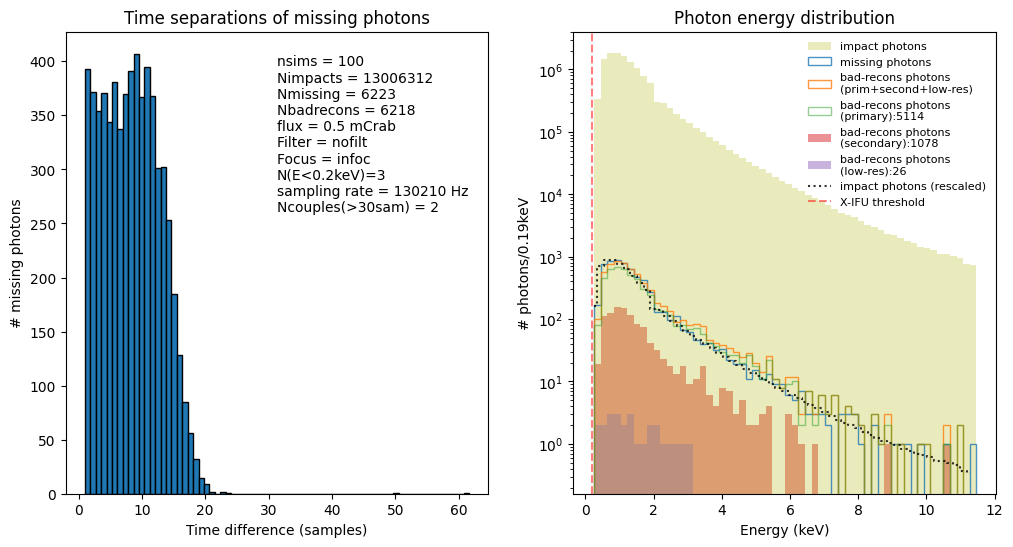

In [21]:
# create a figure with two plots
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))
# In ax1: plot histogram of distances (in samples) for missing photons
# =====================================================================
#ax1.hist(missing_distances, bins=50, edgecolor='black')
hist(all_missing_distances, bins='scott', ax=ax1, edgecolor='black')
ax1.set_xlabel("Time difference (samples)")
ax1.set_ylabel("# missing photons")
ax1.set_title("Time separations of missing photons")
# write text on the plot: number of simulations, flux, exposure, sampling rate
text = (f"nsims = {nsims}\n"
        f"Nimpacts = {Nimpacts}\n"
        f"Nmissing = {Nmissing}\n"
        f"Nbadrecons = {Nbadrecons}\n"
        f"flux = {flux_mcrab} mCrab\n"
        f"Filter = {filter}\n"
        f"Focus = {focus}\n"
        f"N(E<0.2keV)={Nlow_total}\n"
        f"sampling rate = {sampling_rate} Hz\n"
        f"Ncouples(>{pileup_dist}sam) = {Ntimes_couples_far}\n") 

ax1.text(0.5, 0.95, text, transform=ax1.transAxes, fontsize=10, verticalalignment='top')

# In ax2: plot histogram of energies of impact photons, missing photons and bad-reconstructed photons
# =====================================================================
Ncts_bin, miss_bins, handle_miss = hist(all_missing_energies,ax=ax2, alpha=0.8, bins='scott',histtype='step',label=["missing photons"], color='C0', log=True)
bin_size = miss_bins[1] - miss_bins[0]
_, _, handle_bad = hist(all_badrecons_energies,ax=ax2,alpha=0.8, bins=miss_bins,histtype='step',label=["bad-recons photons\n(prim+second+low-res)"], color='C1',log=True)

if len(all_badrecons_energies_primaries) > 0:
    _, _, handle_prim = hist(all_badrecons_energies_primaries,ax=ax2,alpha=0.5, bins=miss_bins,histtype='step',label=[f"bad-recons photons\n(primary):{nbadprim}"],color='C2', log=True)
if len(all_badrecons_energies_secondaries) > 0:
    _, _, handle_sec = hist(all_badrecons_energies_secondaries,ax=ax2,alpha=0.5, bins=miss_bins,label=[f"bad-recons photons\n(secondary):{nbadsec}"], color='C3',log=True)
if len(all_badrecons_energies_lowres) > 0:
    _, _, handle_low = hist(all_badrecons_energies_lowres,ax=ax2,alpha=0.5, bins=miss_bins,label=[f"bad-recons photons\n(low-res):{nbadlowres}"], color='C4',log=True)
# add evt photon energy distribution to histogram
_, _, handle_all = hist(impact_energies,ax=ax2,alpha=0.3, bins=miss_bins,label=["impact photons"], color='C8',log=True)
# plot a vertical line at 0.2 keV
handle_xifu = ax2.axvline(x=0.2, color='r', linestyle='--', alpha=0.5, label="X-IFU threshold")

# add re-scaled "handle_all" histogram to see if it keeps the same shape than the missing histogram
all_np_hist, _ = np.histogram(impact_energies, bins=miss_bins)
scaling_factor = Ncts_bin.sum() / all_np_hist.sum() # miss/all
rescaled_all = all_np_hist * scaling_factor
# Plot the rescaled histogram
handle_re = ax2.step(miss_bins[:-1], rescaled_all, where='mid', linestyle=':', color='black', 
         label="impact photons (rescaled)", alpha=0.8)

# add legend in an specific order
handles = [handle_all[0], handle_miss[0], handle_bad[0], handle_prim[0], handle_sec[0], handle_low[0], handle_re[0],handle_xifu]
labels = [h.get_label() for h in handles]
ax2.legend(handles, labels, loc='upper right', fontsize=8, frameon=False)

ax2.set_xlabel("Energy (keV)")
ax2.set_ylabel(f"# photons/{bin_size:.2f}keV")
ax2.set_title("Photon energy distribution")
plt.show()
# save image to PDF file
fig.savefig(f"./Figures/missing_{filter}_{focus}_{flux_mcrab:.2f}mCrab.pdf", bbox_inches='tight')


### Image of combinations of energies of the bad-recons and their corresponding missing partner

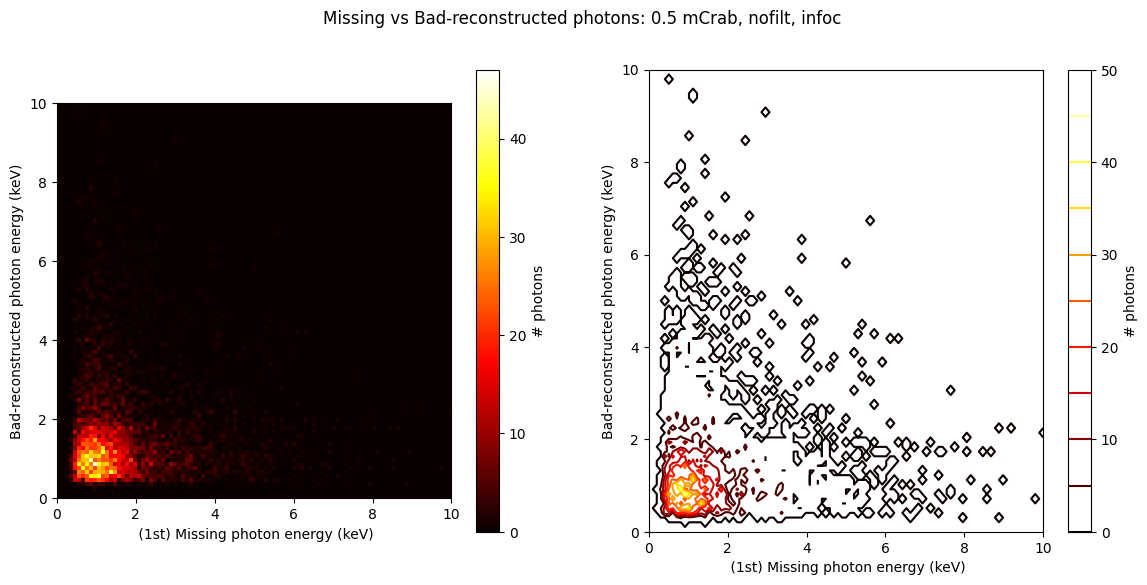

In [22]:
# create 2D map
# X axis: energies of bad-reconstructed photons
# Y axis: energies of missing photons (first of them if there are more than one for the same bad-reconstructed photon)
# =====================================================================
# create a 2D histogram
histo_miss_bad = np.histogram2d(miss0_energies, all_badrecons_energies, bins=[np.linspace(0, 10, 100), np.linspace(0, 10, 100)])
# create a figure
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14, 6))
# add title
fig.suptitle(f"Missing vs Bad-reconstructed photons: {flux_mcrab} mCrab, {filter}, {focus}")
# plot the histogram as an image
im = ax1.imshow(histo_miss_bad[0], cmap='hot', interpolation='nearest', origin='lower', extent=[0, 10, 0, 10])
# label x as "Missing photon energy (keV)"
ax1.set_xlabel(" (1st) Missing photon energy (keV)")
# label y as "Bad-reconstructed photon energy (keV)"
ax1.set_ylabel("Bad-reconstructed photon energy (keV)")
# add colorbar
cbar = plt.colorbar(im, ax=ax1)
cbar.set_label("# photons")

# plot the histogram as a contour plot
contour = ax2.contour(histo_miss_bad[0], levels=10, cmap='hot', extent=[0, 10, 0, 10])
# label x as "Missing photon energy (keV)"
ax2.set_xlabel(" (1st) Missing photon energy (keV)")
# label y as "Bad-reconstructed photon energy (keV)"
ax2.set_ylabel("Bad-reconstructed photon energy (keV)")
# add colorbar
cbar = plt.colorbar(contour, ax=ax2)
cbar.set_label("# photons")
# save image to PDF file
fig.savefig(f"./Figures/missing_vs_badrecons_{filter}_{focus}_{flux_mcrab:.2f}mCrab.pdf", bbox_inches='tight')
